DATASET extraido de : https://www.kaggle.com/code/shivamagarwal29/brain-tumor-classification

In [8]:
# Instalamos librerías necesarias
!pip install -q segmentation-models-pytorch torchvision albumentations torchmetrics  --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 62.8 MB/s eta 0:00:00


In [9]:
from tqdm.auto import tqdm

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from torchmetrics.classification import (
    BinaryAccuracy, BinaryPrecision, BinaryRecall,
    BinaryF1Score, BinaryAUROC
)
import matplotlib.pyplot as plt

In [2]:
import zipfile
import os, io
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import torch
import os
from pathlib import Path
import torchvision.models as models
import torch.nn as nn
import numpy as np
import random
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset


SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:
DATA_ZIP   = "/content/archive.zip"
RAW_DIR    = Path("data")
IMG_ROOT   = RAW_DIR / "Brain Tumor Data Set" / "Brain Tumor Data Set"
SPLIT_FILE = Path("splits.json")
root = "data/Brain Tumor Data Set/Brain Tumor Data Set"


if not RAW_DIR.exists():
    RAW_DIR.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(DATA_ZIP) as zf:
        zf.extractall(RAW_DIR)
    print("✅ Archivo descomprimido correctamente.")
else:
    print("📂 Dataset ya descomprimido.")


✅ Archivo descomprimido correctamente.


In [4]:
for root, dirs, files in os.walk("data"):
    level = root.replace("data", "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    for f in files[:5]:  # mostrar solo 5 archivos por carpeta
        print(f"{indent}  {f}")


data/
  metadata_rgb_only.csv
  metadata.csv
  Brain Tumor Data Set/
    Brain Tumor Data Set/
      Healthy/
        Not Cancer  (2041).jpg
        Not Cancer  (37).jpg
        Not Cancer  (13).jpg
        Not Cancer  (14).jpg
        Not Cancer  (1887).jpg
      Brain Tumor/
        Cancer (324).jpg
        Cancer (93).jpg
        Cancer (538).jpg
        Cancer (390).jpg
        Cancer (844).jpg


### Preparacion Dataset

In [18]:
class BrainTumorDataset(Dataset):
    """
    root_dir → “…/data/Brain Tumor Data Set/Brain Tumor Data Set”
    Estructura esperada:
        root_dir/
            Healthy/
                *.jpg|*.png|…
            Brain Tumor/
                *.jpg|*.png|…
    Etiquetas:
        Brain Tumor → 1
        Healthy     → 0
    """
    IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

    def __init__(self, root_dir, transform=None):
        root_dir      = Path(root_dir)
        self.pos_dir  = root_dir / "Brain Tumor"
        self.neg_dir  = root_dir / "Healthy"
        self.images = self._gather(self.pos) + self._gather(self.neg)
        self.transform = transform

    def _gather(self, folder):
        """Devuelve una lista de rutas de imagen en todas las subcarpetas."""
        return [p for p in folder.rglob("*") if p.suffix.lower() in self.IMG_EXTS]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image    = Image.open(img_path).convert("RGB")
        label    = 1 if "Brain Tumor" in img_path.parts else 0

        if self.transform:
            image = self.transform(image)

        return image, label

In [31]:
# Transformaciones
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize([0.5], [0.5])
])
transform_ = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Crear dataset
root = "data/Brain Tumor Data Set/Brain Tumor Data Set"
full_ds   = BrainTumorDataset(root_dir=root, transform=None)
if   hasattr(full_ds, "imgs"):
    paths = full_ds.imgs
elif hasattr(full_ds, "images"):
    paths = full_ds.images
else:
    raise AttributeError("No encuentro el atributo con las rutas de las imágenes.")

labels = [1 if "Brain Tumor" in p.parts else 0 for p in paths]

labels = [1 if "Brain Tumor" in p.parts else 0 for p in full_ds.images]
# 1º: separar test (20 %)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.10, random_state=SEED)
train_val_idx, test_idx = next(sss.split(np.zeros(len(labels)), labels))

# 2º: separar val (10 de 100 ⇒ 10 / 90 = 0.125)
val_frac = 0.20 / 0.90
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_frac, random_state=SEED)
train_idx, val_idx = next(sss2.split(
    np.zeros(len(train_val_idx)),
    np.array(labels)[train_val_idx]
))

train_ds = Subset(full_ds, np.array(train_val_idx)[train_idx])
val_ds   = Subset(full_ds, np.array(train_val_idx)[val_idx])
test_ds  = Subset(full_ds, np.array(test_idx))

# asignar transforms
train_ds.dataset.transform = transform_train
val_ds.dataset.transform   = transform_
test_ds.dataset.transform  = transform_

print(f"📊 Tamaños → train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")

# ----------------------------------------------------------
# 5. Dataloaders
# ----------------------------------------------------------
BATCH_SIZE  = 16
NUM_WORKERS = 2 if torch.cuda.is_available() else 0
PIN         = torch.cuda.is_available()

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=PIN)


📊 Tamaños → train: 3219, val: 921, test: 460


# Entrenamiento

### Metricas

In [36]:
def init_metrics():
    return {
        'acc':  BinaryAccuracy().to(device),
        'prec': BinaryPrecision().to(device),
        'rec':  BinaryRecall().to(device),
        'f1':   BinaryF1Score().to(device),
        'auc':  BinaryAUROC().to(device)
    }

def update_metrics(mdict, logits, labels):
    """
    logits : Tensor [B, 2]  (sin softmax)
    labels : Tensor [B]     (0 ó 1)
    """
    probs = logits.softmax(1)[:, 1]          # P(clase=1)  →  shape [B]
    mdict['acc'].update(probs,  labels)      # BinaryAccuracy: admite probs
    mdict['prec'].update(probs, labels)
    mdict['rec'].update(probs,  labels)
    mdict['f1'].update(probs,   labels)
    mdict['auc'].update(probs,  labels)

def compute_metrics(mdict):
    return {k: v.compute().item() for k,v in mdict.items()}

### Modelo

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar DenseNet121 preentrenado
model = models.densenet121(pretrained=True)

# Reemplazar la última capa para 2 clases
model.classifier = nn.Linear(model.classifier.in_features, 2)

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 134MB/s]


mejora de chaty

for p in model.features.parameters():
    p.requires_grad = False

model.classifier = nn.Sequential(
    nn.BatchNorm1d(model.classifier.in_features),
    nn.Dropout(0.3),
    nn.Linear(model.classifier.in_features, 2)
)
model = model.to(device)

In [34]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)


In [37]:
EPOCHS      = 10
best_val    = float('inf')
checkpoint  = Path("best_model.pt")

for epoch in range(1, EPOCHS+1):
    # --- train ---
    model.train()
    running = 0.0
    tbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)
    for imgs, lbls in tbar:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss   = criterion(logits, lbls)
        loss.backward()
        optimizer.step()
        running += loss.item()
        tbar.set_postfix(loss=f"{running/len(tbar):.4f}")

    # --- val ---
    model.eval()
    val_loss = 0.0
    vm = init_metrics()
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            logits = model(imgs)
            val_loss += criterion(logits, lbls).item()
            update_metrics(vm, logits, lbls)
    val_loss /= len(val_loader)
    scheduler.step(val_loss)
    vm_res = compute_metrics(vm)

    print(f"🧐 Ep {epoch:02d} | "
          f"val_loss={val_loss:.4f} "
          f"acc={vm_res['acc']:.3f} "
          f"P={vm_res['prec']:.3f} R={vm_res['rec']:.3f} "
          f"F1={vm_res['f1']:.3f} AUC={vm_res['auc']:.3f}")

    # checkpoint
    if val_loss < best_val:
        best_val = val_loss
        torch.save({'model_state': model.state_dict(),
                    'epoch': epoch, 'val_loss': val_loss},
                   checkpoint)
        print("💾 guardado mejor modelo")



Epoch 1/10:   0%|          | 0/202 [00:00<?, ?it/s]

🧐 Ep 01 | val_loss=0.0401 acc=0.990 P=0.996 R=0.986 F1=0.991 AUC=0.998
💾 guardado mejor modelo


Epoch 2/10:   0%|          | 0/202 [00:00<?, ?it/s]

🧐 Ep 02 | val_loss=0.0447 acc=0.990 P=1.000 R=0.982 F1=0.991 AUC=0.999


Epoch 3/10:   0%|          | 0/202 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7949d7fceb60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
     self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
      ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7949d7fceb60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

🧐 Ep 03 | val_loss=0.0337 acc=0.988 P=0.990 R=0.988 F1=0.989 AUC=0.999
💾 guardado mejor modelo


Epoch 4/10:   0%|          | 0/202 [00:00<?, ?it/s]

🧐 Ep 04 | val_loss=0.0266 acc=0.992 P=0.996 R=0.990 F1=0.993 AUC=1.000
💾 guardado mejor modelo


Epoch 5/10:   0%|          | 0/202 [00:00<?, ?it/s]

🧐 Ep 05 | val_loss=0.0301 acc=0.991 P=0.996 R=0.988 F1=0.992 AUC=0.999


Epoch 6/10:   0%|          | 0/202 [00:00<?, ?it/s]

🧐 Ep 06 | val_loss=0.0417 acc=0.987 P=0.990 R=0.986 F1=0.988 AUC=0.999


Epoch 7/10:   0%|          | 0/202 [00:00<?, ?it/s]

🧐 Ep 07 | val_loss=0.0416 acc=0.988 P=0.992 R=0.986 F1=0.989 AUC=0.999


Epoch 8/10:   0%|          | 0/202 [00:00<?, ?it/s]

🧐 Ep 08 | val_loss=0.0386 acc=0.990 P=0.996 R=0.986 F1=0.991 AUC=1.000


Epoch 9/10:   0%|          | 0/202 [00:00<?, ?it/s]

🧐 Ep 09 | val_loss=0.0392 acc=0.990 P=0.996 R=0.986 F1=0.991 AUC=1.000


Epoch 10/10:   0%|          | 0/202 [00:00<?, ?it/s]

🧐 Ep 10 | val_loss=0.0343 acc=0.991 P=0.996 R=0.988 F1=0.992 AUC=1.000


In [38]:
# Evaluación rápida
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"✅ Precisión en test: {100 * correct / total:.2f}%")


✅ Precisión en test: 99.35%


In [39]:
# ----------------------------------------------------------
# 9. Evaluación final en test
# ----------------------------------------------------------
ckpt = torch.load(checkpoint, map_location=device)
model.load_state_dict(ckpt['model_state'])
model.eval()

y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs  = logits.softmax(1)[:,1].cpu().numpy()
        preds  = logits.argmax(1).cpu().numpy()
        y_prob.extend(probs)
        y_pred.extend(preds)
        y_true.extend(lbls.numpy())

print("\n🔬 Test report")
print(classification_report(y_true, y_pred, target_names=["No tumor", "Tumor"], digits=4))


🔬 Test report
              precision    recall  f1-score   support

    No tumor     0.9858    0.9952    0.9905       209
       Tumor     0.9960    0.9880    0.9920       251

    accuracy                         0.9913       460
   macro avg     0.9909    0.9916    0.9912       460
weighted avg     0.9913    0.9913    0.9913       460



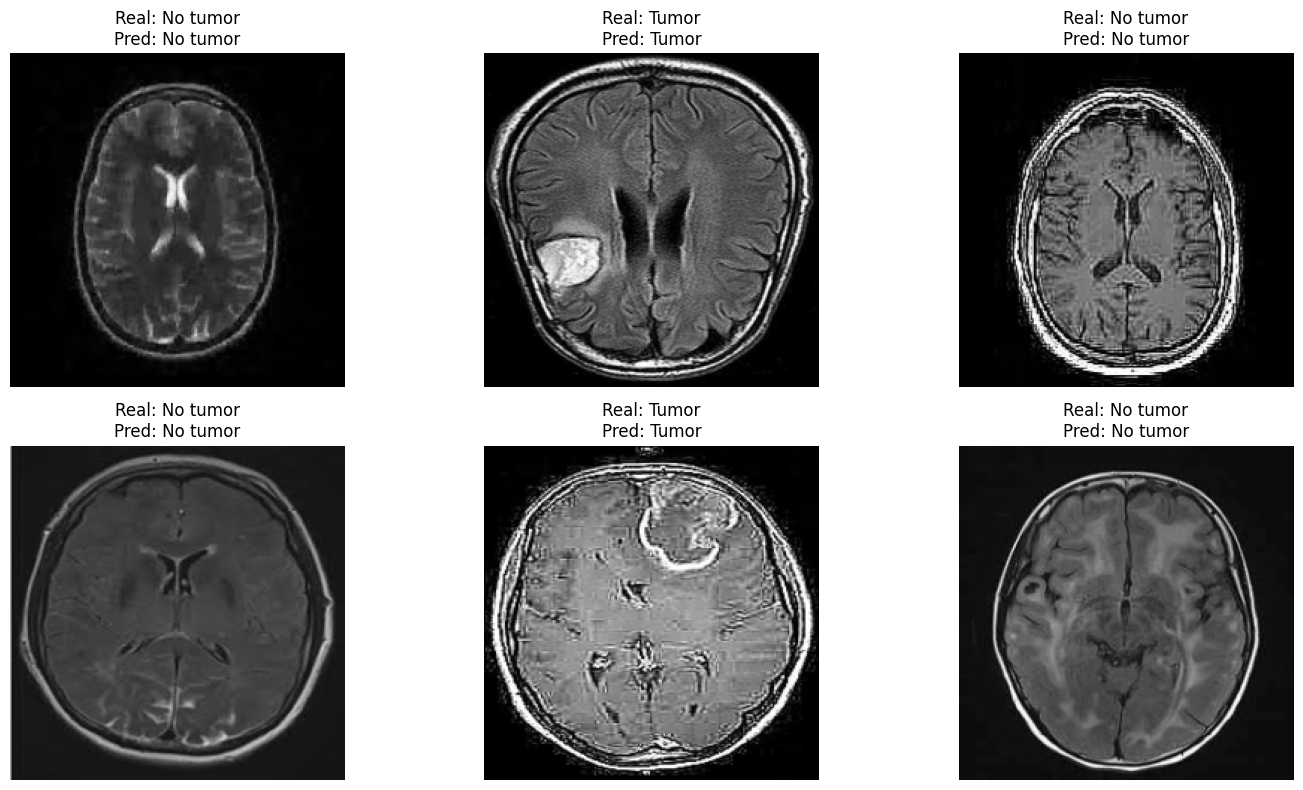

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Clases
class_names = ['No tumor', 'Tumor']

# Mostrar n imágenes del test set con predicción
def show_predictions(model, dataloader, num_images=6):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(15, 8))

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break

                image = images[i].cpu().permute(1, 2, 0).numpy()
                image = (image * 0.5) + 0.5  # Desnormalizar

                label = labels[i].item()
                pred = preds[i].item()

                plt.subplot(2, 3, images_shown + 1)
                plt.imshow(image)
                plt.title(f"Real: {class_names[label]}\nPred: {class_names[pred]}")
                plt.axis('off')

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

# Ejecutar visualización
show_predictions(model, test_loader, num_images=6)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


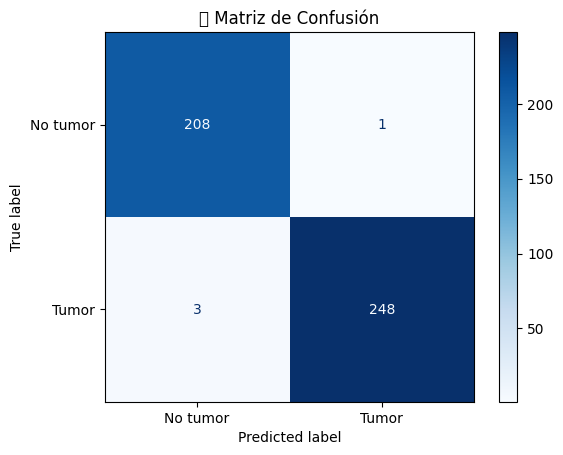

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Obtener etiquetas verdaderas y predichas
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.cpu().numpy())

# Mostrar matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No tumor', 'Tumor'])
disp.plot(cmap='Blues')
plt.title("🧩 Matriz de Confusión")
plt.show()


<ipython-input-42-b2466fb8ba5c>:28: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


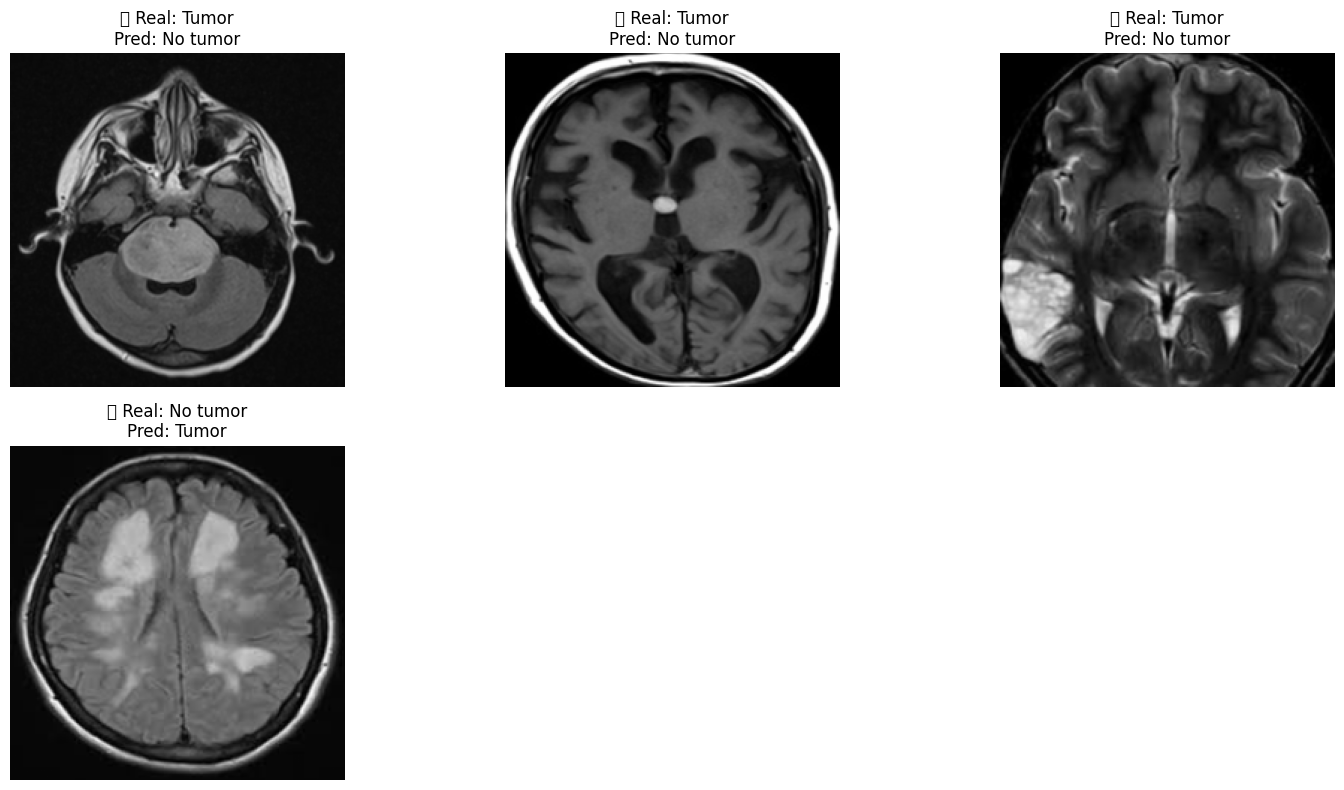

In [42]:
def show_misclassified(model, dataloader, num_images=6):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(15, 8))
    class_names = ['No tumor', 'Tumor']

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if preds[i] != labels[i] and images_shown < num_images:
                    image = images[i].cpu().permute(1, 2, 0).numpy()
                    image = (image * 0.5) + 0.5  # Desnormalizar

                    plt.subplot(2, 3, images_shown + 1)
                    plt.imshow(image)
                    plt.title(f"❌ Real: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}")
                    plt.axis('off')
                    images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

# Ejecutar
show_misclassified(model, test_loader, num_images=8)


In [43]:
#  GUARDAR EL MODELO COMPLETO
# -----------------------------
pkl_path = "brain_tumor_classifier.pkl"
torch.save(model, pkl_path)
print(f"✅ Guardado el modelo: {pkl_path}")

✅ Guardado el modelo: brain_tumor_classifier.pkl


In [44]:
zip_path = "brain_tumor_classifier.zip"

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    # arcname → nombre que tendrá dentro del zip
    zf.write(pkl_path, arcname=os.path.basename(pkl_path))

print(f"✅ Comprimido en: {zip_path}")

✅ Comprimido en: brain_tumor_classifier.zip


In [45]:
# 3) CARGAR EL MODELO COMPLETO
model_from_pkl = torch.load(
    "brain_tumor_classifier.pkl",
    map_location=device,
    weights_only=False
)
print("📦 Modelo cargado desde .pkl")

📦 Modelo cargado desde .pkl


In [46]:
if False:
  with zipfile.ZipFile(zip_path, "r") as zf:
    # Leemos el contenido binario del pkl dentro del zip
    pkl_bytes = zf.read(os.path.basename(pkl_path))

    # Lo pasamos a un buffer en memoria para torch.load
    buffer = io.BytesIO(pkl_bytes)
    model_from_zip = torch.load(
    "brain_tumor_classifier.pkl",
    map_location=device,
    weights_only=False
)
    print("📦 Modelo cargado desde .zip (en memoria)")

In [51]:
from google.colab import files

# Supongamos que tu archivo se llama 'mi_archivo.csv'
nombre_del_archivo = zip_path

# Verifica que el archivo existe (opcional, pero útil para depurar)
import os
if os.path.exists(nombre_del_archivo):
    print(f"El archivo '{nombre_del_archivo}' existe. Intentando descargar...")
    files.download(nombre_del_archivo)

El archivo 'brain_tumor_classifier.zip' existe. Intentando descargar...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Prediccion

In [47]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
class_names = ["No tumor", "Tumor"]

def predict(image_path: str):
    img = Image.open(image_path).convert("RGB")
    tensor = transform_train(img).unsqueeze(0).to(DEVICE)        # [1,3,224,224]
    with torch.no_grad():
        logits = model(tensor)
        probs  = torch.softmax(logits, dim=1)[0]            # [2]
        pred   = probs.argmax().item()

    print(f"🖼️ Imagen: {image_path}")
    print(f"✅ Predicción: {class_names[pred]} "
          f"(p={probs[pred]:.3f})")

    # opcional: visualizar
    plt.imshow(img)
    plt.title(f"{class_names[pred]} (p={probs[pred]:.2f})")
    plt.axis("off")
    plt.show()

🖼️ Imagen: data/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (18).jpg
✅ Predicción: No tumor (p=1.000)


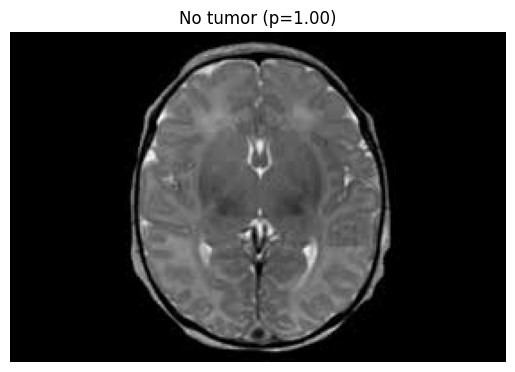

In [50]:
predict("data/Brain Tumor Data Set/Brain Tumor Data Set/Healthy/Not Cancer  (18).jpg")